### Homework 4: Accumulation Opportunity - Hengxu Zhu 12368409

## Import Packages

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp
import functools
import seaborn as sns
import plotnine as p9
import datetime
from statsmodels.tsa.ar_model import AutoReg 
import warnings 
from datetime import datetime
from datetime import timedelta
warnings.filterwarnings('ignore')

## Load Data

In [2]:
book_btc_usd = pd.read_csv('book_narrow_BTC-USD_2023.delim.gz', delimiter='\t', compression='gzip')

In [3]:
book_btc_usd['timestamp'] = pd.to_datetime(book_btc_usd['timestamp_utc_nanoseconds']) 
book_btc_usd = book_btc_usd.set_index(book_btc_usd['timestamp']).drop(columns='timestamp')

The trade data is the actual data I will be using since it contains all the filled trades and can work as an actual reference for prediction. I have also changed all timestamps to datetimes and convert the Size and Prices to gain readability.

In [44]:
trades_btc_usd_2023 = pd.read_csv('trades_narrow_BTC-USD_2023.delim.gz', delimiter='\t', compression='gzip') 
trades_btc_usd_2022 = pd.read_csv('trades_narrow_BTC-USD_2022.delim.gz', delimiter='\t', compression='gzip') 
trades_btc_usd_2021 = pd.read_csv('trades_narrow_BTC-USD_2021.delim.gz', delimiter='\t', compression='gzip') 
trades_btc_usd_2023 = trades_btc_usd_2023.sort_values(by='timestamp_utc_nanoseconds')
trades_btc_usd_2022 = trades_btc_usd_2022.sort_values(by='timestamp_utc_nanoseconds')
trades_btc_usd_2021 = trades_btc_usd_2021.sort_values(by='timestamp_utc_nanoseconds') 
trades_btc_usd = pd.concat([trades_btc_usd_2021, trades_btc_usd_2022]) 
trades_btc_usd = pd.concat([trades_btc_usd, trades_btc_usd_2023]) 
trades_btc_usd['timestamp'] = pd.to_datetime(trades_btc_usd['timestamp_utc_nanoseconds']) 
trades_btc_usd = trades_btc_usd.set_index(trades_btc_usd['timestamp']).drop(columns='timestamp')
price_const = 10**(-6) 
size_const = 10**(-9) 
trades_btc_usd['Size'] = trades_btc_usd['SizeBillionths'] * size_const 
trades_btc_usd['Price'] = trades_btc_usd['PriceMillionths'] * price_const 
trades_btc_usd.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,Size,Price
timestamp,,,,,,,
2021-04-10 21:28:52.515484,1618090136118837000,1618090132515484000,59120710000,9701240,-1.0,0.009701,59120.71
2021-04-10 21:28:52.515484,1618090136118594000,1618090132515484000,59125070000,8122450,-3.0,0.008122,59125.07
2021-04-10 21:28:52.989553,1618090136147838000,1618090132989553000,59119950000,6563880,-1.0,0.006564,59119.95
2021-04-10 21:28:52.989553,1618090136147583000,1618090132989553000,59125070000,614120,-1.0,0.000614,59125.07
2021-04-10 21:28:53.074765,1618090136153326000,1618090133074765000,59119950000,16995890,-1.0,0.016996,59119.95


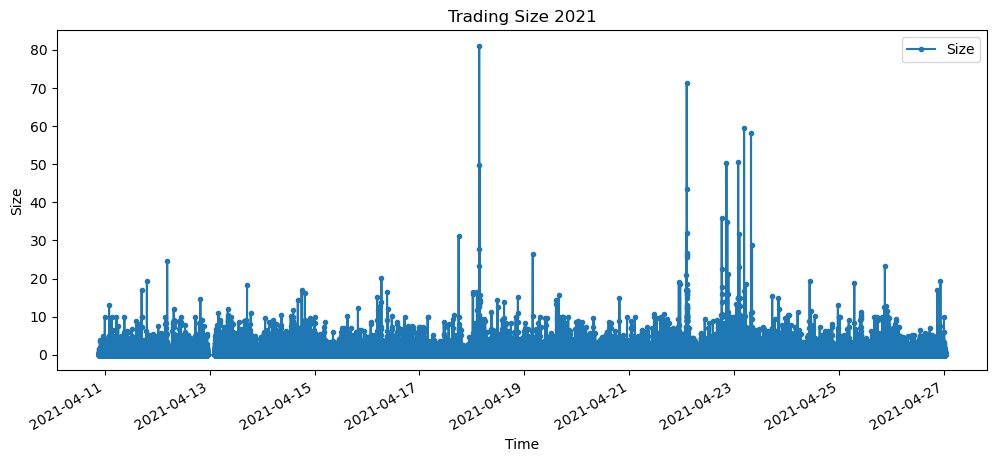

In [95]:
trades_btc_usd[['Size']][:'2021'].plot(title= "Trading Size 2021", 
ylabel = "Size", xlabel = "Time", figsize = (12,5),style='.-');

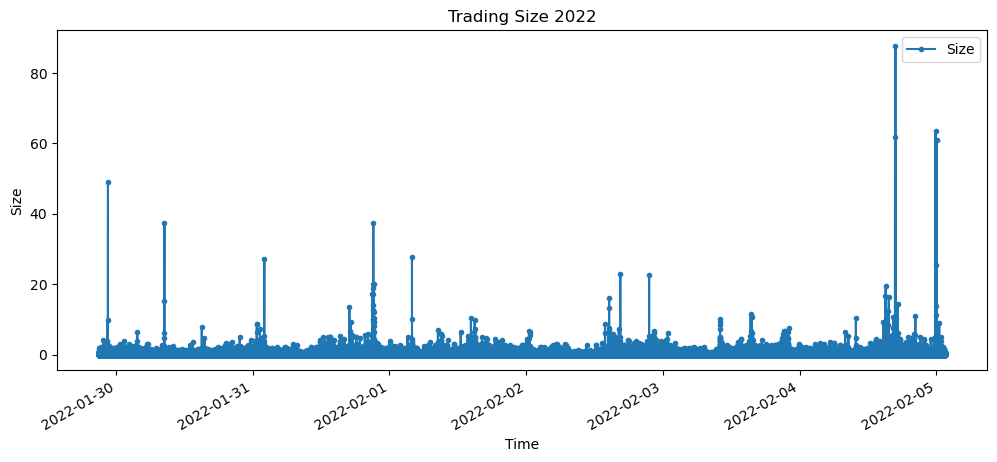

In [96]:
trades_btc_usd[['Size']]['2022':'2022'].plot(title= "Trading Size 2022", 
ylabel = "Size", xlabel = "Time", figsize = (12,5),style='.-');

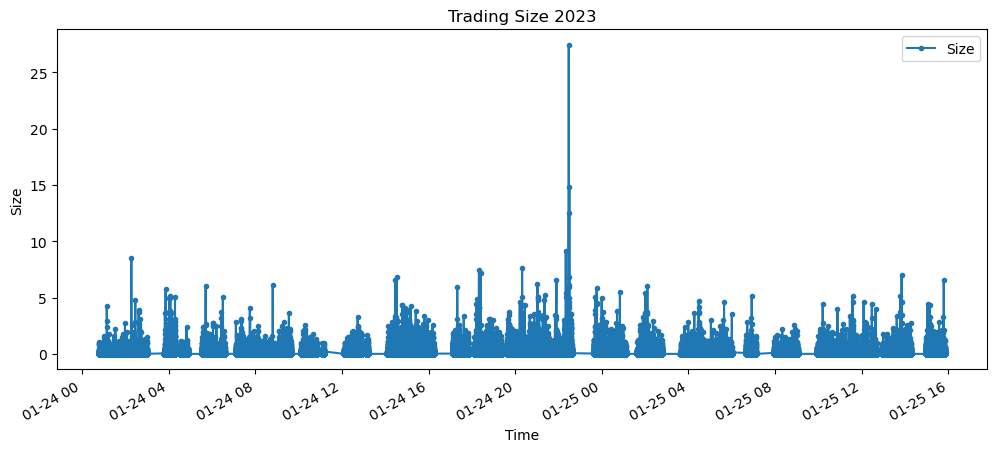

In [97]:
trades_btc_usd[['Size']]['2023':'2023'].plot(title= "Trading Size 2023", 
ylabel = "Size", xlabel = "Time", figsize = (12,5),style='.-');

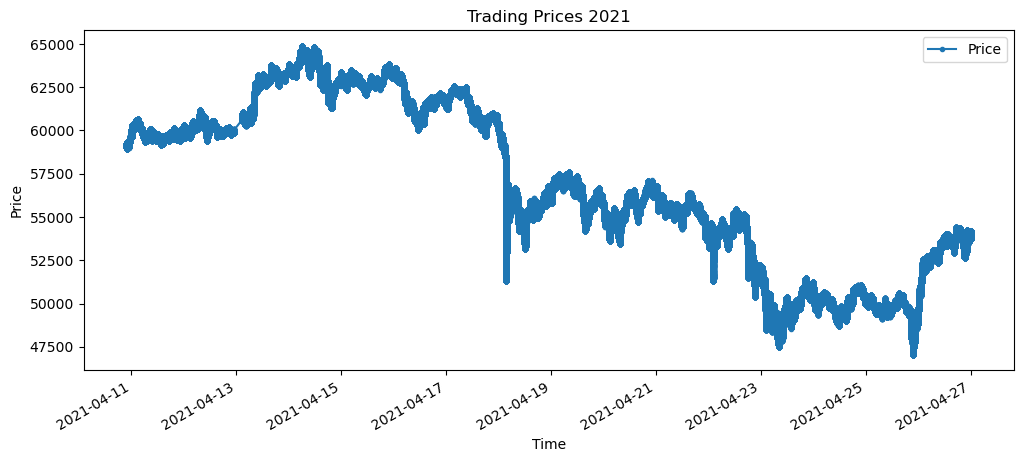

In [98]:
trades_btc_usd[['Price']][:'2021'].plot(title= "Trading Prices 2021", 
ylabel = "Price", xlabel = "Time", figsize = (12,5),style='.-');

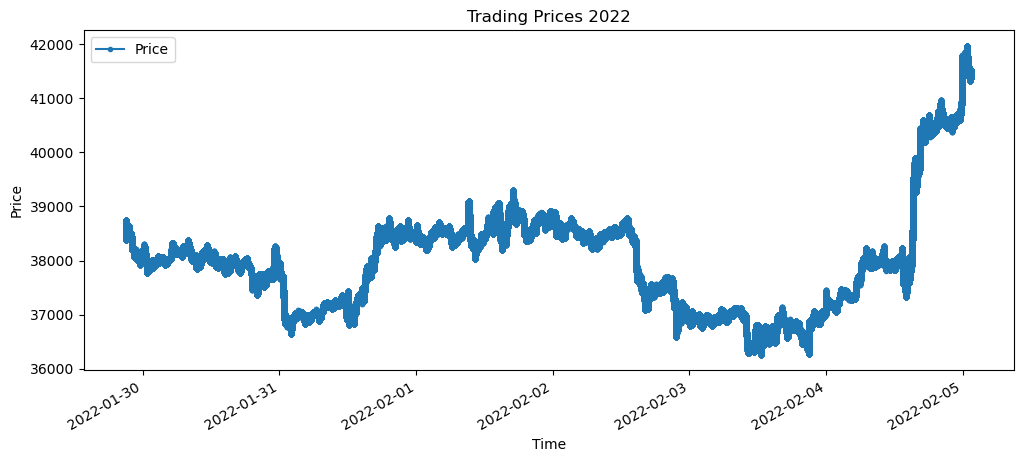

In [99]:
trades_btc_usd[['Price']]['2022':'2022'].plot(title= "Trading Prices 2022", 
ylabel = "Price", xlabel = "Time", figsize = (12,5),style='.-');

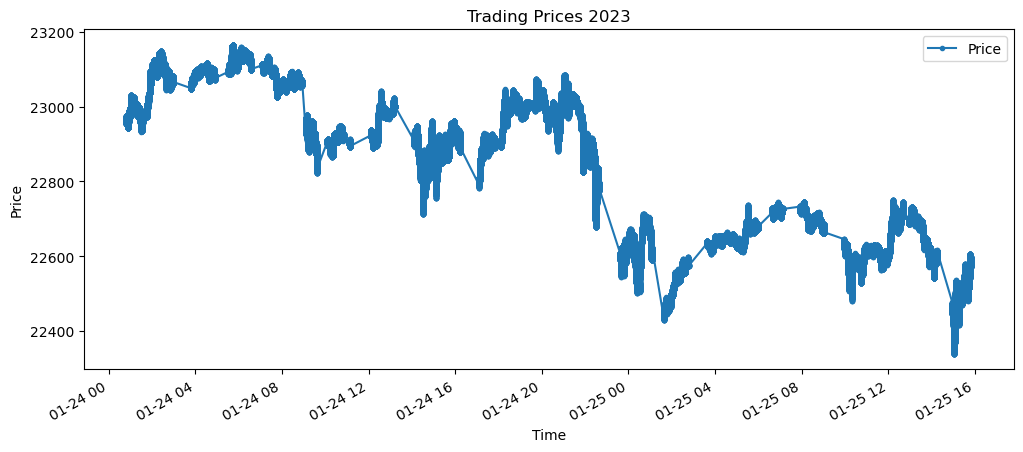

In [100]:
trades_btc_usd[['Price']]['2023':'2023'].plot(title= "Trading Prices 2023", 
ylabel = "Price", xlabel = "Time", figsize = (12,5),style='.-');

## Implement Algorithm 

As the accumulation algorithms intends to balance the cost of trading and the time to finish the trading, the most important factor to analyze are target quantity Q, target participation rate p. 

Our algorithm starts with the Q and p and trys to participate the trades based on the size of the previous timestamp with a rate of p. When the previous trade size is large, we would like to increase our participation rate to fill the Q faster and avoid falling behind. To better show this is more effective than falling behind, I will write two algorithms, one with a changing p and one with a fixed p. I allow p to change between 10 and 20% when the size is large. 

Aftering evaluating p, we need to choose a time interval for a specific arrival time. I will choose 15 minutes as this is the largest allowing window for this homework. Most of the transaction processes should complete within this time interval. The function I wrote allows you to have a larger window, but be aware that choosing a very large window makes no sense as we are trying to complete the traction effeciently.

In addition, we need to set a chunk rate c to trigger the trading process at a timepoint. This is also important as this chunk rate is the key factor to drive the participation rate and fill the order quantity Q. Therefore, I decided to choose this chunk rate as the 20% percentile of the Size in the 15-minute window. Meanwhile, p will equal to 5% at this point and change to 10% when the Size reach the 50% percentile of the Size. 

#### Prepare the dataframe 

Being aware that there are duplicating timestamp, I decided to combine all the duplicated timestamps and set the combined size factor as the sum of the size of these timestamps. As for the prices, I would like to only include the worst price since this will provide us better predictions in the real world by generating a worst case scenario. Therefore, when the Side factor indicates a buy action, we will purchase the highest price at that timestamp. The logic goes another way around for a short action.

In [45]:
def preparation(df, Q, arrival, interval): 
    df_acc = df.copy()
    
    if Q > 0: 
        df_acc = df_acc[df_acc['Side'] > 0] 
        df_acc = df_acc.groupby('timestamp').agg(
            {'Price': 'max', 'Size': 'sum'})
    else: 
        df_acc = df_acc[df_acc['Side'] < 0] 
        df_acc = df_acc.groupby('timestamp').agg(
            {'Price': 'min', 'Size': 'sum'}) 
        
    date_format_str = '%Y-%m-%d %H:%M:%S.%f'
    arrival = trades_btc_usd.sample().index.tolist()[0]
    end = arrival + timedelta(minutes=interval)
    df_acc = df_acc[arrival:end] 
    
    return df_acc 

In [46]:
prepare_ex = preparation(trades_btc_usd, 1, '2021-04-10 21:30:00.000', 15)
prepare_ex.tail()

,Price,Size
timestamp,,
2021-04-14 05:12:07.348732,64375.13,0.015487
2021-04-14 05:12:07.460031,64375.13,0.001499
2021-04-14 05:12:07.836404,64375.13,0.000722
2021-04-14 05:12:08.342488,64375.13,0.030453
2021-04-14 05:12:09.418524,64384.59,0.018276


#### Fixed Participation Rate Algorithm

For both the Fixed and Floating participation rate, the accumulation process will calculate the trading volume V and trading notional PV which is also Price * Volume. Both factors are cumulative summations. We also devide the cumsum of PV by the cumsum of V to get the VWAP. In addition, we deduct Q by the amount of each Price * Volume and shut down the process when Q reaches 0. 

In [47]:
def accumulation_fixed(df, Q, arrival, interval): 
    
    df_acc = preparation(df, Q, arrival, interval) 
    c = df_acc['Size'].quantile(0.2) 
    p = 0.1
    
    df_acc['Participation'] = df_acc['Size'].shift(1) * p 
    
    df_acc['V'] = 0 
    df_acc['PV'] = 0 
    df_acc['Q'] = 0 
    
    for i in range(1, len(df_acc)): 
        if df_acc['Size'][i-1] >= c: 
            df_acc['V'][i] = df_acc['V'][i-1] + df_acc['Participation'][i]
            df_acc['PV'][i] = df_acc['PV'][i-1] + df_acc['Participation'][i] * df_acc['Price'][i] 
            df_acc['Q'][i] = Q - df_acc['PV'][i]
        else: 
            df_acc['V'][i] = df_acc['V'][i-1] 
            df_acc['PV'][i] = df_acc['PV'][i-1] 
            df_acc['Q'][i] = df_acc['Q'][i-1]
            
    df_acc['Q'] = np.where(df_acc['Q'] < 0, 0, df_acc['Q'])
    df_acc['VWAP'] = df_acc['PV']/df_acc['V'] 
    df_acc = df_acc.dropna() 
    
    return df_acc

In [101]:
fixed_ex = accumulation_fixed(trades_btc_usd, 100000, '2021-04-10 21:30:00.000', 15)
fixed_ex[fixed_ex['Q']!=0].tail()

,Price,Size,Participation,V,PV,Q,VWAP
timestamp,,,,,,,
2022-02-04 21:35:46.443649,40499.0,0.000246,0.000236,2.277236,92275.963214,7724.036786,40521.029621
2022-02-04 21:35:46.611675,40499.0,0.749240,0.000025,2.277261,92276.959287,7723.040713,40521.029383
2022-02-04 21:35:46.621896,40499.0,0.500000,0.074924,2.352185,95311.306363,4688.693637,40520.327683
2022-02-04 21:35:46.622440,40499.0,0.494100,0.050000,2.402185,97336.256363,2663.743637,40519.883760
2022-02-04 21:35:46.627604,40499.0,0.474577,0.049410,2.451595,99337.311953,662.688047,40519.462864


#### Floating Participation Rate Algorithm

To avoid the case of falling behind, we allow the change of participation rate for this algorithm. That is to we need to calculate the participation amount individually for each timestamp. 

In [49]:
def accumulation_float(df, Q, arrival, interval): 
    
    df_acc = preparation(df, Q, arrival, interval) 
    c = df_acc['Size'].quantile(0.2) 
    c_up = df_acc['Size'].quantile(0.5) 
    p = 0.05 
    p_up = 0.1
    
    df_acc['V'] = 0 
    df_acc['PV'] = 0 
    df_acc['Q'] = 0 
    df_acc['Participation'] = 0
    
    for i in range(1, len(df_acc)): 
        if df_acc['Size'][i-1] >= c: 
            if df_acc['Size'][i-1] >= c_up: 
                df_acc['Participation'][i] = df_acc['Size'][i-1] * p_up 
                df_acc['V'][i] = df_acc['V'][i-1] + df_acc['Participation'][i]
                df_acc['PV'][i] = df_acc['PV'][i-1] + df_acc['Participation'][i] * df_acc['Price'][i] 
                df_acc['Q'][i] = Q - df_acc['PV'][i]
            else: 
                df_acc['Participation'][i] = df_acc['Size'][i-1] * p
                df_acc['V'][i] = df_acc['V'][i-1] + df_acc['Participation'][i]
                df_acc['PV'][i] = df_acc['PV'][i-1] + df_acc['Participation'][i] * df_acc['Price'][i] 
                df_acc['Q'][i] = Q - df_acc['PV'][i]
        else: 
            df_acc['V'][i] = df_acc['V'][i-1] 
            df_acc['PV'][i] = df_acc['PV'][i-1] 
            df_acc['Q'][i] = df_acc['Q'][i-1]
            
    df_acc['Q'] = np.where(df_acc['Q'] < 0, 0, df_acc['Q'])
    df_acc['VWAP'] = df_acc['PV']/df_acc['V'] 
    df_acc = df_acc.dropna() 
    
    return df_acc

In [102]:
float_ex = accumulation_float(trades_btc_usd, 100000, '2021-04-10 21:30:00.000', 15)
float_ex[float_ex['Q']!=0].tail()

,Price,Size,V,PV,Q,Participation,VWAP
timestamp,,,,,,,
2021-04-16 15:56:41.622006,61722.06,0.015884,1.594921,98476.241784,1523.758216,0.000081,61743.656003
2021-04-16 15:56:41.728010,61722.24,0.031768,1.596509,98574.282439,1425.717561,0.001588,61743.634696
2021-04-16 15:56:42.038785,61722.19,0.001395,1.599686,98770.363591,1229.636409,0.003177,61743.592109
2021-04-16 15:56:42.398115,61722.57,0.003503,1.599756,98774.668092,1225.331908,0.000070,61743.591192
2021-04-16 15:56:42.572783,61727.03,0.491110,1.600106,98796.288108,1203.711892,0.000350,61743.587567


## Analysis

For this part of the analysis, I will do a sample of 20 arrival times and choose several quantity Q to test the likelihood of completing the entire quantity. 

In addition, we will analyze the difference between average price of accumulated positions and arrival prices. This will be a comparison between the first price in the 15-min window and the last VWAP. 

Also, we will compare the difference between using the floating and fixed participation rate. I will use the VWAP and the likelihood of completing the entire quantity to compare the two algorithms as we may seek for a lower weighted average price and higher possibility to complete if we can have the floating rate.

#### Set Target Quantity 

I am trying to get the sum of the trading notional for each 15-min window and then take the median, 25% and 75% quantile as the target quantity. This value may vary and I just set it as a target range. After selecting the range, I multiplied each number by 10% as this is our normal participation rate.

In [61]:
df_Q = trades_btc_usd.copy() 
df_Q['Notional'] = df_Q['Size'] * df_Q['Price'] 
df_Q = df_Q[['Notional']] 
df_Q = df_Q.resample('15min').sum() 
df_Q = df_Q[df_Q['Notional']!=0] 
df_Q = df_Q.dropna()
rang = [df_Q['Notional'].quantile(0.25), df_Q['Notional'].quantile(0.5), df_Q['Notional'].quantile(0.75)] 
Q = [0.1*(4000000+1000000*i) for i in range(8)]
print(rang) 
print(Q)

[4082437.779802393, 7024913.95144435, 11861312.874745935]
[400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 1000000.0, 1100000.0]


To do a quick test using just 5 arrival times and using the lowest Q in our selection, we can see that for both float and fixed rate, we have a high possibility to have the transaction complete.

In [65]:
rate_fixed = 0 
rate_float = 0 
for i in range(5): 
    arrival = str(trades_btc_usd.sample(random_state = 38).index.tolist()[0]) 
    df_fixed = accumulation_fixed(trades_btc_usd, 400000, arrival, 15) 
    df_float = accumulation_float(trades_btc_usd, 400000, arrival, 15) 
    if len(df_fixed > 0): 
        if df_fixed['Q'][-1] == 0: 
            rate_fixed += 1 
    if len(df_float > 0):        
        if df_float['Q'][-1] == 0: 
            rate_float += 1 
print(rate_fixed/5)
print(rate_float/5)

0.6
0.8


In [63]:
success_fixed = [] 
success_float = [] 

for q in Q: 
    rate_fixed = 0 
    rate_float = 0 
    for i in range(20): 
        arrival = str(trades_btc_usd.sample().index.tolist()[0]) 
        df_fixed = accumulation_fixed(trades_btc_usd, q, arrival, 15) 
        df_float = accumulation_float(trades_btc_usd, q, arrival, 15) 
        if len(df_fixed > 0): 
            if df_fixed['Q'][-1] == 0: 
                rate_fixed += 1 
        if len(df_float > 0):        
            if df_float['Q'][-1] == 0: 
                rate_float += 1 
    success_fixed.append(rate_fixed/100)
    success_float.append(rate_float/100) 
    rate_fixed = 0 
    rate_float = 0 
    
print(success_fixed)
print(success_float) 

[0.14, 0.1, 0.09, 0.11, 0.06, 0.05, 0.05, 0.03]
[0.15, 0.1, 0.13, 0.06, 0.08, 0.08, 0.02, 0.03]


From the graph below, we can easily obeserve that whether we use a float or a fixed participation rate, the likelihood to complete the transaction is trending downward as the target quantity is increasing. However, the float rate does not seem to have any positive effect on promoting this likelihood. It does seem to make the likelihood more volatile. This could be the reason that for different time interval selection, we have some specific interval contains more large sized transaction. This will make more sense if we can do the loop for 1000 or more times rather than 20, but runing the code for 20 times is already time consuming.

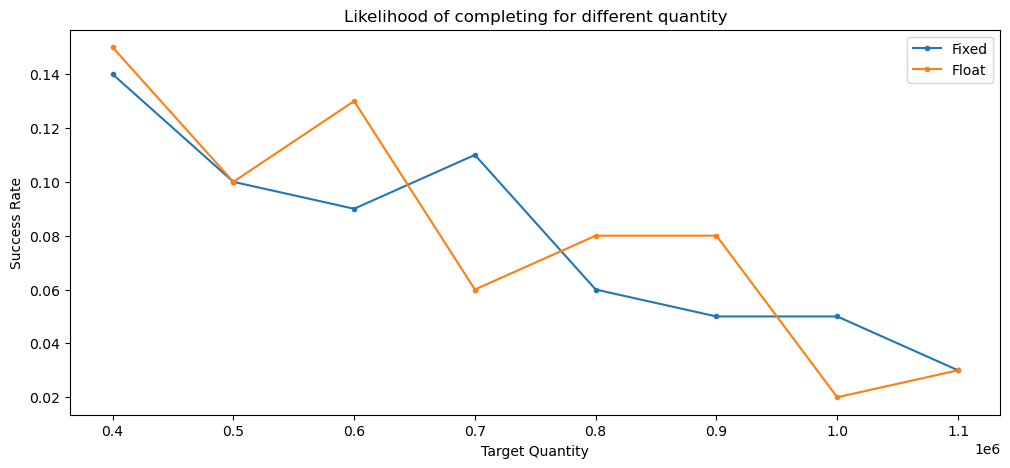

In [83]:
success = pd.DataFrame([success_fixed, success_float]).T
success = success.rename(columns={0: 'Fixed', 1: 'Float'}) 
success = success.set_index([Q])
success.plot(title= "Likelihood of completing for different quantity", 
ylabel = "Success Rate", xlabel = "Target Quantity", figsize = (12,5),style='.-');

In [86]:
diff_arr_VWAP_fixed = [] 
diff_arr_VWAP_float = [] 
for q in Q: 
    arrival = str(trades_btc_usd.sample(random_state = 38).index.tolist()[0]) 
    df_fixed = accumulation_fixed(trades_btc_usd, q, arrival, 15) 
    df_float = accumulation_float(trades_btc_usd, q, arrival, 15) 
    diff_fixed = df_fixed['VWAP'][-1] - df_fixed['Price'][0] 
    diff_float = df_float['VWAP'][-1] - df_float['Price'][0]
    diff_arr_VWAP_fixed.append(diff_fixed)
    diff_arr_VWAP_float.append(diff_float)

From the graph below, we can observe that for both participation rate, we have that difference between our weighted price and the initial arrival price trending to be more stable. This can be intepreted as when we have a larger Q, we tends to have larger number of transaction, more transactions will give us a more stable ending aveage price. 

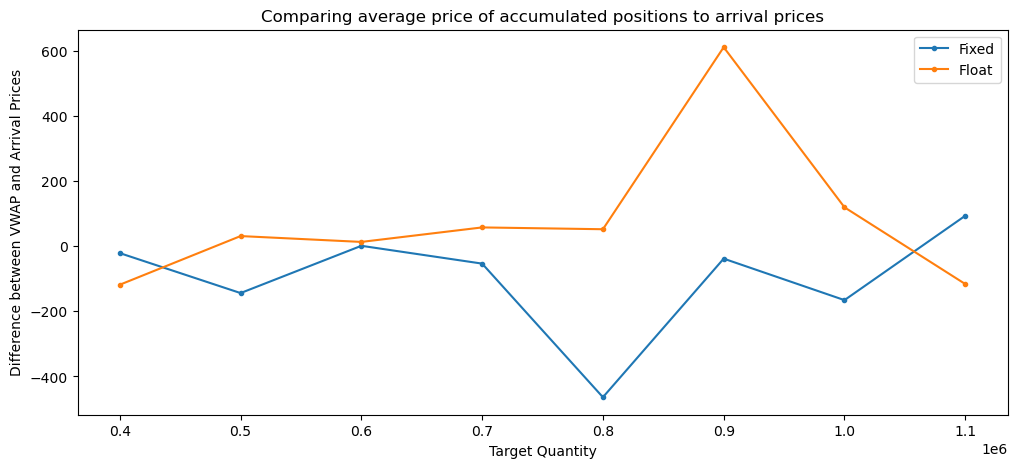

In [87]:
diff = pd.DataFrame([diff_arr_VWAP_fixed, diff_arr_VWAP_float]).T
diff = diff.rename(columns={0: 'Fixed', 1: 'Float'})
diff = diff.set_index([Q])
diff.plot(title= "Comparing average price of accumulated positions to arrival prices", 
ylabel = "Difference between VWAP and Arrival Prices", xlabel = "Target Quantity", figsize = (12,5),style='.-');

## Conclusion 

As I implement the whole process, I think we can include a better method to control the price of the stock for each transaction. This is particularly important to us as the trading notional does not only depend on the size of each purchase. 

If we want to control the trading cost and make sure that we can limit our transaction process to a certain amount of time, we have to include algorithm to track the price. For example, we can include a rate similar to the participation rate and use it to trigger the transaction when the price exceed certain point and also accelerate the process when the price is very low for buying or when the price is very high for shorting.

Lastly, I think I should study more about ways to reduce the running time of my programs. This will facilitate the process and enable me to run a loop of 1000 rather than just 20. This will produce more effective likelihood of completing target quantity and make our analysis more meaningful.